In [ ]:
# Outline of Pipeline
# 1. Get CT source points from vessel extraction
# 1.1 Get tomoRecon points from hand drawn extraction
# 2. Project tomorRecon points onto tomosynthesis projection (using center of emitter, 1 position)
# 3. Make mask with drawn tomoRecon points
# 4. Apply the mask to each of the tomosynthesis projection images
# 5. Get masked tomosynthesis images
# 6. Project and register CT source points with the mask applied to the tomosynthesis projection

In [3]:
import PythonVersorRigid3DPerspectiveTransform as T
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import least_squares
import time
import itk
from itkwidgets import view
import os
from pathlib import Path
import functions as func

In [4]:
# GET FILES
# path to relevent directories and files
# patient 1
# tomoProj_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient01/Patient01"
# tomoRecon_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS01/CS01/CS01A"
# overlay_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS01/CS01/CS01A"
# emitterGeo_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient01/Patient01/geo.txt"
# vessel_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/results/CT-Lungs-Vessels_01.tre"
# ct_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/CTData/CS-01_CT_8.26.20/CT_01_04.nii" 
# vessel_annotation_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS01/CS01/CS01A/overlayMask.dcm"
# destDir = "C:/src/chestTomoPipeline/masks_01"
# parentDir = "C:/src/chestTomoPipeline/"
# solution_output_filename = "regSolution_01.txt"
# x_init = [0, 0, 0, math.pi, math.pi, 0]
# img = itk.imread(ct_file)
# spacing = img.GetSpacing()
# spacing = spacing[0]

In [5]:
# patient 2
tomoProj_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient02/Patient02"
tomoRecon_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS02/CS02/CS02A"
overlay_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS02/CS02/CS02A"
emitterGeo_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient02/Patient02/geo.txt"
vessel_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/results/CT-Lungs-Vessels_02.tre"
ct_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/CTData/CS-02_CT_9.29.20/CT_02_04.nii"
destDir = "C:/src/chestTomoPipeline/masks_02"
parentDir = "C:/src/chestTomoPipeline/"
solution_output_filename = "regSolution_02.txt"
x_init = [0, 55, -25, math.pi, math.pi, 0]
img = itk.imread(ct_file)
spacing = img.GetSpacing()
spacing = spacing[0]

In [6]:
# patient 3
# tomoProj_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient03/Patient03"
# tomoRecon_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS03/CS03/CS03A"
# overlay_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS03/CS03/CS03A"
# emitterGeo_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient03/Patient03/geo.txt"
# vessel_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/results/CT-Lungs-Vessels_03.tre"
# ct_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/CTData/CS-03_CT_11.16.20/CT_03_04.nii" 
# vessel_annotation_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS03/CS03/CS03A/overlayMask.dcm"
# destDir = "C:/src/chestTomoPipeline/masks_03"
# parentDir = "C:/src/chestTomoPipeline/"
# solution_output_filename = "regSolution_03.txt"
# x_init = [20, -275, 45, math.pi, math.pi, 0]
# img = itk.imread(ct_file)
# spacing = img.GetSpacing()
# spacing = spacing[0]

In [7]:
# patient 4
# tomoProj_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient04/Patient04"
# tomoRecon_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS04/CS04/CS04A"
# overlay_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS04/CS04/CS04A"
# emitterGeo_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient04/Patient04/geo.txt"
# vessel_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/results/CT-Lungs-Vessels_04.tre"
# ct_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/CTData/CS-04_CT_11.17.20/CT_04_02.nii" 
# vessel_annotation_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS04/CS04/CS04A/overlayMask.dcm"
# destDir = "C:/src/chestTomoPipeline/masks_04"
# parentDir = "C:/src/chestTomoPipeline/"
# solution_output_filename = "regSolution_04.txt"
# x_init = [-10, -155, 0, math.pi, math.pi, 0]
# img = itk.imread(ct_file)
# spacing = img.GetSpacing()
# spacing = spacing[0]

In [8]:
# patient 5
# tomoProj_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient05/Patient05"
# tomoRecon_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS05/CS05/CS05A"
# overlay_dir = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS05/CS05/CS05A"
# emitterGeo_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/ProjectionData/Patient05/Patient05/geo.txt"
# vessel_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/results/CT-Lungs-Vessels_05.tre"
# ct_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/CTData/CS-05_CT_11.18.20/CT_05_03.nii" 
# vessel_annotation_file = "C:/src/ITKTubeTK-ChestTomosynthesis/data/2022-ChestTomo-Scatter/TomoRecons/CS05/CS05/CS05A/overlayMask.dcm"
# destDir = "C:/src/chestTomoPipeline/masks_05"
# parentDir = "C:/src/chestTomoPipeline/"
# solution_output_filename = "regSolution_05.txt"
# x_init = [-20, -120, 0, math.pi, math.pi, 0]
# img = itk.imread(ct_file)
# spacing = img.GetSpacing()
# spacing = spacing[0]

In [17]:
# number of tomo images and recon files
tomoFileNumber = 36
tomoReconFileNumber = 86

# get list of paths to tomo images (mirrored) and tomoRecon images
tomo_preproccess_list = []
tomo_proj_list = []
mask_list = []
tomo_recon_list = []
overlay_list = []

for i in range(tomoReconFileNumber):
    new_suffix = f'{i+1:03}.dcm'
    file_name = tomoRecon_dir+"/Image_"+new_suffix
    file_path = Path(file_name)
    if os.path.isfile(file_path):
        tomo_recon_list.append(file_name)

for i in range(tomoFileNumber):
    new_suffix = f'{i+1:02}.dcm'
    file_name = tomoProj_dir+"/Image_"+new_suffix
    file_path = Path(file_name)
    if os.path.isfile(file_path):
        tomo_preproccess_list.append(file_name)    

for i in range(tomoFileNumber):
    new_suffix = f'{i+1:03}.dcm'
    file_name = overlay_dir+"/overlayMask_"+new_suffix
    file_path = Path(file_name)
    if os.path.isfile(file_path):
        overlay_list.append(file_name)

# preproccess tomo projections (get mirrored image), and get list of paths 
for path, i in zip(tomo_preproccess_list, range(len(tomo_proj_list))):
    img = itk.imread(path)
    img = itk.GetArrayFromImage(img)
    img = np.squeeze(img)
    img = np.fliplr(img)
    img = itk.GetImageFromArray(img)
    file_name = tomoProj_file+"/Flipped/Image_{}.mha".format(f'{i+1:02}')
    file_path = Path(file_name)
    itk.imwrite(img, file_path)
    
for i in range(tomoFileNumber):
    new_suffix = f'{i+1:02}.dcm'
    file_name = tomoProj_file+"/Flipped/Image_"+new_suffix
    file_path = Path(file_name)
    if os.path.isfile(file_path):
        tomo_proj_list.append(file_name)  
    
# get list of emitter positions
with open(emitterGeo_file) as f:
    lines = f.readlines()
    geo_lines = []
    for line in lines:
        line = str(line)
        line = line.strip("\n").strip("'")
        line = line.split(" ")
        while("" in line) :
            line.remove("")
        geo_lines.append(line)
# first three are "fit" - disregard first line
del geo_lines[0]
for i in geo_lines:
    del i[3:6]
    for num in range(len(i)):
        i[num] = float(i[num])

In [18]:
# GLOBAL VARIABLES
# define x_scale for lsq optimization
x_scale = np.array([1/13000000, 1/13000000, 1/13000000, .000001, .000001, .000001])
# size of tomo projection
size = itk.size(itk.imread(tomo_proj_list[3]))
# size of tomo reconstruction
sizeRecon = itk.size(itk.imread(tomo_recon_list[3]))
# define initial x values
x0 = [0, 0, 0, 0, 0, 0]

#################################
# Set up VersorRigid3DPerspectiveTransform for projectng TomosynthesisRecon Data 
CenterOfRotation = np.array([0, 0, 0])                         # not used in the transform point (using center of field)
PlaneCenter = np.array([sizeRecon[0]/2, sizeRecon[1]/2, 0])    # center of detector
PlaneNormal = np.array([0, 0, 1])                              # vector normal
xDirection = np.array([sizeRecon[0]/2+1, sizeRecon[1]/2, 0])   # vector x direction
yDirection = np.array([sizeRecon[0]/2, sizeRecon[1]/2+1, 0])   # vector y direction
line_15 = geo_lines[15]                                        # define projection position for general calcs/visualization
EmitterPosition = [(sizeRecon[0]/2)*0.194-line_15[0], (sizeRecon[1]/2)*0.194+line_15[1], line_15[2]]
#################################
project = T.VersorRigid3DPerspectiveTransform(CenterOfRotation, EmitterPosition, PlaneCenter, PlaneNormal, xDirection, yDirection)

#################################
# Set up VersorRigid3DPerspectiveTransform for projecting CT Data
CenterOfRotation = np.array([0, 0, 0])                     # not used in the transform point (using center of field)
PlaneCenter = np.array([0, 0, 0])                          # center of detector
PlaneNormal = np.array([0, 0, 1])                          # vector normal
xDirection = np.array([1, 0, 0])                           # vector x direction
yDirection = np.array([0, 1, 0])                           # vector y direction
EmitterPosition =[-line_15[0], line_15[1], line_15[2]]
#################################
projectCT = T.VersorRigid3DPerspectiveTransform(CenterOfRotation, EmitterPosition, PlaneCenter, PlaneNormal, xDirection, yDirection)

In [19]:
# 1. Get CT source points from vessel extraction
Dimension = 3

reader = itk.SpatialObjectReader[Dimension].New()
reader.SetFileName(vessel_file)
reader.Update()
tubes = reader.GetGroup()

castSO = itk.CastSpatialObjectFilter[3].New()
castSO.SetInput(tubes)
tubesSO = castSO.GetTubes()
points = []
radii = []

for i in range(tubes.GetNumberOfChildren()):
    tube = tubesSO[i]
    p = list(map(lambda x: tube.GetPoint(x).GetPositionInObjectSpace(), range(tube.GetNumberOfPoints())))
    for i in p:
        points.append(i)
    r = list(map(lambda x: tube.GetPoint(x).GetRadiusInObjectSpace(), range(tube.GetNumberOfPoints())))
    for j in r:
        radii.append(j)

points = np.array(points)
radii = np.array(radii)
source_points = np.ones([len(points), 3])
for i, point in zip(range(len(points)), points):
    source_points[i] = [point[0], point[2], point[1]]

view(image=itk.imread(ct_file), point_sets=tubes)

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157, 0.       , 0.       ]], dtype…

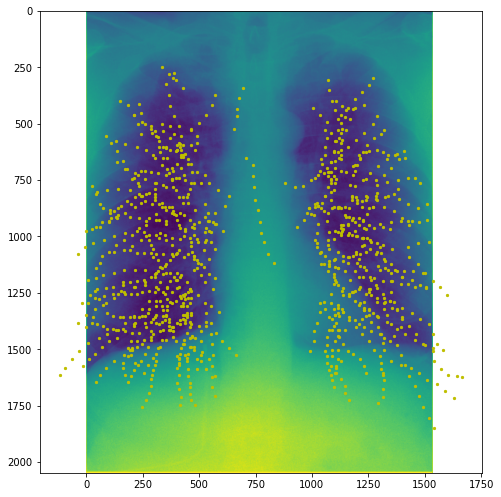

In [20]:
# Perform initial transform on CT Points and get subset of CT source points to use for optimzation
# visualize for verification
source = func.TransformAllPointsAllParameters(x_init, source_points[1::100])
projectedPoints, _, _= func.GetProjectedPointsCTTP(source, projectCT, size, spacing)
plt.close()
plt.rcParams["figure.figsize"] = (12,8.5)
img = itk.imread(tomo_proj_list[15])
img = np.squeeze(img)
fig, ax = plt.subplots()
ax.imshow(img)
for point in projectedPoints:
    line1 = plt.scatter(point[0], point[1], 5, c='y')
plt.show()

In [21]:
# 1.1 Get tomoRecon points from hand drawn extraction
mask = []
for vessel_annotation_file in overlay_list:
    img = itk.imread(vessel_annotation_file)
    img.SetSpacing((0.194, 0.194, 1))
    imgarr = itk.GetArrayFromImage(img)
    point = np.argwhere(imgarr>0)
    for index in point:
        mask.append([index[2]*0.194, index[1]*0.194, 35*3])
mask = np.array(mask)

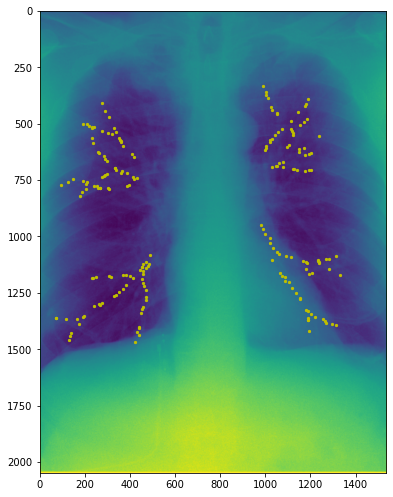

In [22]:
# 2. Project tomorRecon points onto tomosynthesis projection (using center of emitter, 1 position)
# check to make sure it projects to generally right area
projectedPoints, _, _= func.GetProjectedPointsTRTP(mask, project, sizeRecon)

plt.close()
plt.rcParams["figure.figsize"] = (12,8.5)
img = itk.imread(tomo_proj_list[15])
img = np.squeeze(img)
fig, ax = plt.subplots()
ax.imshow(img)
for point in projectedPoints[1::200]:
    line1 = plt.scatter(point[0], point[1], 5, c='y')
plt.show()

In [10]:
# 3. Make mask with drawn tomoRecon points
func.MakeVesselMask(geo_lines, mask, size, destDir)

line 1 of 29 complete
line 2 of 29 complete
line 3 of 29 complete
line 4 of 29 complete
line 5 of 29 complete
line 6 of 29 complete
line 7 of 29 complete
line 8 of 29 complete
line 9 of 29 complete
line 10 of 29 complete
line 11 of 29 complete
line 12 of 29 complete
line 13 of 29 complete
line 14 of 29 complete
line 15 of 29 complete
line 16 of 29 complete
line 17 of 29 complete
line 18 of 29 complete
line 19 of 29 complete
line 20 of 29 complete
line 21 of 29 complete
line 22 of 29 complete
line 23 of 29 complete
line 24 of 29 complete
line 25 of 29 complete
line 26 of 29 complete
line 27 of 29 complete
line 28 of 29 complete
line 29 of 29 complete


In [11]:
# 4. Apply the mask to each of the tomosynthesis projection images
for i in range(len(tomo_proj_list)):
    inputIm = itk.imread(tomo_proj_list[i], itk.F)
    inputIm = np.squeeze(inputIm)
    inputIm = itk.GetImageFromArray(inputIm)
    maskCT = itk.imread(destDir+"/mask_ct_{}.dcm".format(f'{i+1:02}'), itk.UC)
    maskCT = np.squeeze(maskCT)
    maskCT = maskCT.astype(dtype=np.uint8)
    maskCT = itk.GetImageFromArray(maskCT)

    ImageType = itk.Image[itk.F, 2]
    MaskType = itk.Image[itk.UC, 2]
    MaskFilterType = itk.MaskImageFilter[ImageType, MaskType, ImageType]
    maskFilter = MaskFilterType.New()
    maskFilter.SetInput(inputIm)
    maskFilter.SetMaskImage(maskCT)
    maskFilter.Update()
    itk.imwrite(maskFilter.GetOutput(), destDir+"/maskProjection_{}.mha".format(f'{i+1:02}'))

In [12]:
# 5. Get masked tomosynthesis images
for i in range(36):
    file_name = destDir+"/maskProjection_{}.mha".format(f'{i+1:02}')
    file_path = Path(file_name)
    if os.path.isfile(file_path):
        mask_list.append(file_name)    

In [22]:
# 6. Project and register CT source points with the mask applied to the tomosynthesis projection
u = np.array(source[1::5])
y = geo_lines

t0 = time.time()
res_trf = least_squares(func.CT_TomoProjectionRegistration, x0*x_scale, args=(u, y, mask_list, x_scale, size, spacing), 
                        verbose=2, method='trf', tr_options={"regularize": False}, 
                        bounds=[-3, 3], diff_step=[0.9, 0.9, 0.9, 0.1, 0.1, 0.1],
                        gtol=1e-15, xtol=1e-15)
t1 = time.time()
print("Optimization took {} seconds".format(t1 - t0))

Optimized point 1 of 223
Optimized point 2 of 223
Optimized point 3 of 223
Optimized point 4 of 223
Optimized point 5 of 223
Optimized point 6 of 223
Optimized point 7 of 223
Optimized point 8 of 223
Optimized point 9 of 223
Optimized point 10 of 223
Optimized point 11 of 223
Optimized point 12 of 223
Optimized point 13 of 223
Optimized point 14 of 223
Optimized point 15 of 223
Optimized point 16 of 223
Optimized point 17 of 223
Optimized point 18 of 223
Optimized point 19 of 223
Optimized point 20 of 223
Optimized point 21 of 223
Optimized point 22 of 223
Optimized point 23 of 223
Optimized point 24 of 223
Optimized point 25 of 223
Optimized point 26 of 223
Optimized point 27 of 223
Optimized point 28 of 223
Optimized point 29 of 223
Optimized point 30 of 223
Optimized point 31 of 223
Optimized point 32 of 223
Optimized point 33 of 223
Optimized point 34 of 223
Optimized point 35 of 223
Optimized point 36 of 223
Optimized point 37 of 223
Optimized point 38 of 223
Optimized point 39 of

Optimized point 204 of 223
Optimized point 205 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 206 of 223
Optimized point 207 of 223
Optimized point 208 of 223
Optimized point 209 of 223
Optimized point 210 of 223
Optimized point 211 of 223
Optimized point 212 of 223
Optimized point 213 of 223
Optimized point 214 of 223
Optimized point 215 of 223
Optimized point 216 of 223
Optimized point 217 of 223
Optimized point 218 of 223
Optimized point 219 of 223
Optimized point 220 of 223
Optimized point 221 of 223
Optimized point 222 of 223
Optimized point 223 of 223
5264.030462347302 [0. 0. 0. 0. 0. 0.]
Optimized point 

Optimized point 167 of 223
Optimized point 168 of 223
Optimized point 169 of 223
Optimized point 170 of 223
Optimized point 171 of 223
Optimized point 172 of 223
Optimized point 173 of 223
Optimized point 174 of 223
Optimized point 175 of 223
Optimized point 176 of 223
Optimized point 177 of 223
Optimized point 178 of 223
Optimized point 179 of 223
Optimized point 180 of 223
Optimized point 181 of 223
Optimized point 182 of 223
Optimized point 183 of 223
Optimized point 184 of 223
Optimized point 185 of 223
Optimized point 186 of 223
Optimized point 187 of 223
Optimized point 188 of 223
Optimized point 189 of 223
Optimized point 190 of 223
Optimized point 191 of 223
Optimized point 192 of 223
Optimized point 193 of 223
Optimized point 194 of 223
Optimized point 195 of 223
Optimized point 196 of 223
Optimized point 197 of 223
Optimized point 198 of 223
Optimized point 199 of 223
Optimized point 200 of 223
Optimized point 201 of 223
Optimized point 202 of 223
Optimized point 203 of 223
O

Optimized point 129 of 223
Optimized point 130 of 223
Optimized point 131 of 223
Optimized point 132 of 223
Optimized point 133 of 223
Optimized point 134 of 223
Optimized point 135 of 223
Optimized point 136 of 223
Optimized point 137 of 223
Optimized point 138 of 223
Optimized point 139 of 223
Optimized point 140 of 223
Optimized point 141 of 223
Optimized point 142 of 223
Optimized point 143 of 223
Optimized point 144 of 223
Optimized point 145 of 223
Optimized point 146 of 223
Optimized point 147 of 223
Optimized point 148 of 223
Optimized point 149 of 223
Optimized point 150 of 223
Optimized point 151 of 223
Optimized point 152 of 223
Optimized point 153 of 223
Optimized point 154 of 223
Optimized point 155 of 223
Optimized point 156 of 223
Optimized point 157 of 223
Optimized point 158 of 223
Optimized point 159 of 223
Optimized point 160 of 223
Optimized point 161 of 223
Optimized point 162 of 223
Optimized point 163 of 223
Optimized point 164 of 223
Optimized point 165 of 223
O

Optimized point 106 of 223
Optimized point 107 of 223
Optimized point 108 of 223
Optimized point 109 of 223
Optimized point 110 of 223
Optimized point 111 of 223
Optimized point 112 of 223
Optimized point 113 of 223
Optimized point 114 of 223
Optimized point 115 of 223
Optimized point 116 of 223
Optimized point 117 of 223
Optimized point 118 of 223
Optimized point 119 of 223
Optimized point 120 of 223
Optimized point 121 of 223
Optimized point 122 of 223
Optimized point 123 of 223
Optimized point 124 of 223
Optimized point 125 of 223
Optimized point 126 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 127 of 223


out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 78 of 223
Optimized point 79 of 223
Optimized point 80 of 223
Optimized point 81 of 223
Optimized point 82 of 223
Optimized point 83 of 223
Optimized point 84 of 223
Optimized point 85 of 223
Optimized point 86 of 223
Optimized point 87 of 223
Optimized point 88 of 223
Optimized point 89 of 223
Optimized point 90 of 223
Optimized point 91 of 223
Optimized point 92 of 223
Optimized point 93 of 223
Optimized point 94 of 223
Optimized point 95 of 223
Optimized point 96 of 223
Optimized point 97 of 223
Optimized point 98 of 223
Optimized point 99 of 223
Optimized point 100 of 223
Optimized point 101 of 223
Optimized point 102 of 223
Optimized point 103 of 223
Optimized point 104 of 223
Optimized point 105 of 223
Optimized point 106 of 223
O

Optimized point 62 of 223
Optimized point 63 of 223
Optimized point 64 of 223
Optimized point 65 of 223
Optimized point 66 of 223
Optimized point 67 of 223
Optimized point 68 of 223
Optimized point 69 of 223
Optimized point 70 of 223
Optimized point 71 of 223
Optimized point 72 of 223
Optimized point 73 of 223
Optimized point 74 of 223
Optimized point 75 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 76 of 223
Optimized point 77 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 49 of 223
Optimized point 50 of 223
Optimized point 51 of 223
Optimized point 52 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 53 of 223
Optimized point 54 of 223
Optimized point 55 of 223
Optimized point 56 of 223
Optimized point 57 of 223
Optimized point 58 of 223
Optimized point 59 of 223
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
ou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 2 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 3 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 21 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 22 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 23 of 223
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 40 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 41 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 42 of 223
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 61 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 79 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 80 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 98 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 99 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 117 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 118 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 136 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 137 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 155 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 156 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 174 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 193 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 194 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 212 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 213 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 8 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 9 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 27 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 46 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 47 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 65 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 66 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 84 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 85 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 103 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 104 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 105 of 223
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
Optimized point 122 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 123 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 124 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 142 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 143 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 161 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 162 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 180 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 181 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 199 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 200 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 218 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 219 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 14 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 15 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 33 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 34 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 35 of 223
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 53 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 54 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 72 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 73 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 92 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 110 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 111 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 129 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 130 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 148 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 149 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimize

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 168 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 169 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 187 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 188 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 206 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 207 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 2 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 3 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 21 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 22 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 40 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 41 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 59 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 78 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 79 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 97 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 98 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 116 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 117 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 135 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 136 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 137 of 223
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 155 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 156 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 174 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 193 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 194 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 212 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 213 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 8 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 9 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 27 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 46 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 47 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 65 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 66 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 67 of 223
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 84 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 85 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 86 of 223
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 103 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 104 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 105 of 223
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 123 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 124 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 142 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 143 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 161 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 162 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 180 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 181 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 199 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 200 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 218 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 219 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 14 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 15 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 33 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 34 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 52 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 53 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 71 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 72 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 90 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
Optimized point 109 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 110 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 111 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 129 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 130 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 148 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 149 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 167 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 168 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 186 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 187 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 188 of 223
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 205 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 206 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 207 of 223
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 1 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 2 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 3 of 223
out of bounds
o

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 21 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 22 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 40 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 41 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 59 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 78 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 79 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 80 of 223
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 98 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 99 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 117 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 118 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 136 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 137 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 155 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 156 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 174 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 193 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 194 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 195 of 223
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 213 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 214 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 9 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 10 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of boun

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 29 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 47 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 48 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 66 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 67 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 85 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 86 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 87 of 223
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 104 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 105 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 106 of 223
out of bounds
out of bo

out of bounds
Optimized point 123 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 124 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 125 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 143 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 144 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 162 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 163 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 181 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 182 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 200 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 201 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 219 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 220 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 15 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 16 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized 

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 34 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 35 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 36 of 223
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 53 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 54 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 55 of 223
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
Optimized point 72 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 73 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 74 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 92 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 93 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 111 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 112 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 130 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 131 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 149 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 150 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 168 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 169 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 187 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 188 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 206 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 207 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 208 of 223
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 2 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 3 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
Optimized point 21 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 22 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 23 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 41 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 42 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 61 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 79 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 80 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 99 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 100 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 118 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 119 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 137 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 138 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 156 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 157 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 158 of 223
out of bounds
out of bounds
out of bo

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 176 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 177 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 195 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 196 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 214 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 215 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 29 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 30 of 223
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 54 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 55 of 223
Optimized point 56 of 223
Optimized point 57 of 223
Optimized point 58 of 223
Optimized point 59 of 223
Optimized point 60 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 92 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 93 of 223
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 132 of 223
Optimized point 133 of 223
Optimized point 134 of 223
out of bounds
out of bounds
Optimized point 135 of 223
Optimized point 136 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 137 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bound

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 172 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 173 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 174 of 223
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 206 of 223
Optimized point 207 of 223
Optimized point 208 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 209 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bou

out of bounds
Optimized point 54 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 55 of 223
Optimized point 56 of 223
Optimized point 57 of 223
Optimized point 58 of 223
Optimized point 59 of 223
Optimized point 60 of 223
Optimized point 61 of 223
Optimized point 62 of 223
Optimized point 63 of 223
Optimized point 64 of 223
Optimized point 65 of 223
Optimized point 66 of 223
Optimized point 67 of 223
Optimized point 68 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of b

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 123 of 223
Optimized point 124 of 223
Optimized point 125 of 223
Optimized point 126 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 127 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of boun

Optimized point 189 of 223
Optimized point 190 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 191 of 223
Optimized point 192 of 223
Optimized point 193 of 223
Optimized point 194 of 223
Optimized point 195 of 223
Optimized point 196 of 223
Optimized point 197 of 223
Optimized point 198 of 223
Optimized point 199 of 223
Optimized point 200 of 223
Optimized point 201 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out o

Optimized point 118 of 223
Optimized point 119 of 223
Optimized point 120 of 223
Optimized point 121 of 223
Optimized point 122 of 223
Optimized point 123 of 223
Optimized point 124 of 223
Optimized point 125 of 223
Optimized point 126 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 127 of 223
Optimized point 128 of 223
Optimized point 129 of 223
Optimized point 130 of 223
Optimized point 131 of 223
Optimized point 132 of 223
Optimized point 133 of 223
Optimized point 134 of 223
Optimized point 135 of 223
Optimized point 136 of 223
Optimized point 137 of 223
Optimized point 138 of 223
Optimized point 139 of 223


Optimized point 63 of 223
Optimized point 64 of 223
Optimized point 65 of 223
Optimized point 66 of 223
Optimized point 67 of 223
Optimized point 68 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 69 of 223
Optimized point 70 of 223
Optimized point 71 of 223
Optimized point 72 of 223
Optimized point 73 of 223
Optimized point 74 of 223
Optimized point 75 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out 

Optimized point 203 of 223
Optimized point 204 of 223
Optimized point 205 of 223
Optimized point 206 of 223
Optimized point 207 of 223
Optimized point 208 of 223
Optimized point 209 of 223
Optimized point 210 of 223
Optimized point 211 of 223
Optimized point 212 of 223
Optimized point 213 of 223
Optimized point 214 of 223
Optimized point 215 of 223
Optimized point 216 of 223
Optimized point 217 of 223
Optimized point 218 of 223
Optimized point 219 of 223
Optimized point 220 of 223
Optimized point 221 of 223
Optimized point 222 of 223
Optimized point 223 of 223
5125.989948971703 [-0.30789072  0.07264435 -0.02650271  0.06575598 -0.06902693 -0.03713235]
Optimized point 1 of 223
Optimized point 2 of 223
Optimized point 3 of 223
Optimized point 4 of 223
Optimized point 5 of 223
Optimized point 6 of 223
Optimized point 7 of 223
Optimized point 8 of 223
Optimized point 9 of 223
Optimized point 10 of 223
Optimized point 11 of 223
Optimized point 12 of 223
Optimized point 13 of 223
Optimized po

Optimized point 164 of 223
Optimized point 165 of 223
Optimized point 166 of 223
Optimized point 167 of 223
Optimized point 168 of 223
Optimized point 169 of 223
Optimized point 170 of 223
Optimized point 171 of 223
Optimized point 172 of 223
Optimized point 173 of 223
Optimized point 174 of 223
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 176 of 223
Optimized point 177 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
Optimized point 92 of 223
Optimized point 93 of 223
Optimized point 94 of 223
Optimized point 95 of 223
Optimized point 96 of 223
Optimized point 97 of 223
Optimized point 98 of 223
Optimized point 99 of 223
Optimized point 100 of 223
Optimized point 101 of 223
Optimized point 102 of 223
Optimized point 103 of 223
Optimized point 104 of 223
Optimized point 105 of 223
Optimized point 106 of 223
Optimized point 107 of 223
Optimized point 108 of 223
Optimized point 109 of 223
Optimized point 110 of 223
Optimized point 111 of 223
Optimized point 112 of 223
Optimized point 113 of 223
Optimized point 114 of 223
Optimized point 115 of 223
Optimized point 116 of 223
Optimized point 117 of 223
Optimized poin

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 49 of 223
Optimized point 50 of 223
Optimized point 51 of 223
Optimized point 52 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 53 of 223
Optimized point 54 of 223
Optimized point 55 of 223
Optimized point 56 of 223
Optimized point 57 of 223
Optimized point 58 of 223
Optimized point 59 of 223
Optimized point 60 of 223
Optimized point 61 of 223
Optimized point 62 of 223
Optimized point 63 of 223
Optimized point 64 of 223
Optimized point 65 of 223
Optimized point 66 of 223
Optimized point 67 of 223
Op

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 191 of 223
Optimized point 192 of 223
Optimized point 193 of 223
Optimized point 194 of 223
Optimized point 195 of 223
Optimized point 196 of 223
Optimized point 197 of 223
Optimized point 198 of 223
Optimized point 199 of 223
Optimized point 200 of 223
Optimized point 201 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 202 of 223
Optimized point 203 of 223
Optimized point 204 of 223
Optimized point 205 of 223
Optimized point 206 of 223
Optimized point 207 of 223
Optimized point 208 of 223
Optimized point 209 of 2

Optimized point 134 of 223
Optimized point 135 of 223
Optimized point 136 of 223
Optimized point 137 of 223
Optimized point 138 of 223
Optimized point 139 of 223
Optimized point 140 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 141 of 223
Optimized point 142 of 223
Optimized point 143 of 223
Optimized point 144 of 223
Optimized point 145 of 223
Optimized point 146 of 223
Optimized point 147 of 223
Optimized point 148 of 223
Optimized point 149 of 223
Optimized point 150 of 223
Optimized point 151 of 223
Optimized point 152 of 223
Optimized point 153 of 223
Optimized point 154 of 223
Optimized point 155 of 223


out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 76 of 223
Optimized point 77 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 78 of 223
Optimized point 79 of 223
Optimized point 80 of 223
Optimized point 81 of 223
Optimized point 82 of 223
Optimized point 83 of 223
Optimized point 84 of 223
Optimized point 85 of 223
Optimized point 86 of 223
Optimized point 87 of 223
Optimized point 88 of 223
Optimized point 89

Optimized point 7 of 223
Optimized point 8 of 223
Optimized point 9 of 223
Optimized point 10 of 223
Optimized point 11 of 223
Optimized point 12 of 223
Optimized point 13 of 223
Optimized point 14 of 223
Optimized point 15 of 223
Optimized point 16 of 223
Optimized point 17 of 223
Optimized point 18 of 223
Optimized point 19 of 223
Optimized point 20 of 223
Optimized point 21 of 223
Optimized point 22 of 223
Optimized point 23 of 223
Optimized point 24 of 223
Optimized point 25 of 223
Optimized point 26 of 223
Optimized point 27 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
Optimized point 29 of 223

Optimized point 164 of 223
Optimized point 165 of 223
Optimized point 166 of 223
Optimized point 167 of 223
Optimized point 168 of 223
Optimized point 169 of 223
Optimized point 170 of 223
Optimized point 171 of 223
Optimized point 172 of 223
Optimized point 173 of 223
Optimized point 174 of 223
Optimized point 175 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 176 of 223
Optimized point 177 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of

Optimized point 79 of 223
Optimized point 80 of 223
Optimized point 81 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 82 of 223
Optimized point 83 of 223
Optimized point 84 of 223
Optimized point 85 of 223
Optimized point 86 of 223
Optimized point 87 of 223
Optimized point 88 of 223
Optimized point 89 of 223
Optimized point 90 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
ou

Optimized point 20 of 223
Optimized point 21 of 223
Optimized point 22 of 223
Optimized point 23 of 223
Optimized point 24 of 223
Optimized point 25 of 223
Optimized point 26 of 223
Optimized point 27 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 28 of 223
Optimized point 29 of 223
Optimized point 30 of 223
Optimized point 31 of 223
Optimized point 32 of 223
Optimized point 33 of 223
Optimized point 34 of 223
Optimized point 35 of 223
Optimized point 36 of 223
Optimized point 37 of 223
Optimized point 38 of 223
Optimized point 39 of 223
Optimized point 40 of 223
Optimized point 41 of 223
Optimized point 42 of 

out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 176 of 223
Optimized point 177 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 178 of 223
Optimized point 179 of 223
Optimized point 180 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of boun

Optimized point 83 of 223
Optimized point 84 of 223
Optimized point 85 of 223
Optimized point 86 of 223
Optimized point 87 of 223
Optimized point 88 of 223
Optimized point 89 of 223
Optimized point 90 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
Optimized point 92 of 223
Optimized point 93 of 223
Optimized point 94 of 223
Optimized point 95 of 223
Optimized point 96 of 223
Optimized point 97 of 223
Optimized point 98 of 223
Optimized point 99 of 223
Optimized point 100 of 223
Optimized point 101 of 223
Optimized point 102 of 223
Optimized point 103 of 223
Optimized point 104 of 223
Optimized point 1

Optimized point 29 of 223
Optimized point 30 of 223
Optimized point 31 of 223
Optimized point 32 of 223
Optimized point 33 of 223
Optimized point 34 of 223
Optimized point 35 of 223
Optimized point 36 of 223
Optimized point 37 of 223
Optimized point 38 of 223
Optimized point 39 of 223
Optimized point 40 of 223
Optimized point 41 of 223
Optimized point 42 of 223
Optimized point 43 of 223
Optimized point 44 of 223
Optimized point 45 of 223
Optimized point 46 of 223
Optimized point 47 of 223
Optimized point 48 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 49 of 223
Optimized point 50 of 223
Optimized point 51 of 

out of bounds
out of bounds
out of bounds
Optimized point 176 of 223
Optimized point 177 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 178 of 223
Optimized point 179 of 223
Optimized point 180 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized p

Optimized point 90 of 223
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
out of bounds
Optimized point 91 of 223
Optimized point 92 of 223
Optimized point 93 of 223
Optimized point 94 of 223
Optimized point 95 of 223
Optimized point 96 of 223
Optimized point 97 of 223
Optimized point 98 of 223
Optimized point 99 of 223
Optimized point 100 of 223
Optimized point 101 of 223
Optimized point 102 of 223
Optimized point 103 of 223
Optimized point 104 of 223
Optimized point 105 of 223
Optimized point 106 of 223
Optimized point 107 of 223
Optimized point 108 of 223
Optimized point 109 of 223
Optimized point 110 of 223
Optimized point 111 of 223
Optimized 

RuntimeError: C:\P\IPP\ITK-source\ITK\Modules\Core\Common\include\itkImportImageContainer.hxx:191:
Failed to allocate memory for image.

In [ ]:
# define data
regSolution = np.asarray(res_trf.x/x_scale)
# save to csv file
np.savetxt(parentDir+solution_output_filename, regSolution, delimiter=',')

In [ ]:
source = func.TransformAllPointsAllParameters(x_init, source_points[1::100])
projectedPoints, _, _= func.GetProjectedPointsCTTP(source, projectCT, size, spacing)
transformed = func.TransformAllPointsAllParameters(res_trf.x/x_scale, source)
projectedPoints_opt, _, _ = func.GetProjectedPointsCTTP(transformed, projectCT, size, spacing)

plt.close()
plt.rcParams["figure.figsize"] = (12,8.5)
img = itk.imread(mask_list[15])
img = np.squeeze(img)
fig, ax = plt.subplots()
ax.imshow(img)
for point, opt in zip(projectedPoints, projectedPoints_opt):
    line1 = plt.scatter(point[0], point[1], 10, c='y')
    line2 = plt.scatter(opt[0], opt[1], 10, c='r')
ax.legend([line1, line2], ['Initial', 'Opt'])
plt.show()

In [ ]:
# # Make 2D transformed vessel overlay 
source = func.TransformAllPointsAllParameters(x_init, source_points[1::20])
transformed = func.TransformAllPointsAllParameters(res_trf.x/x_scale, source, spacing)
func.MakeVesselOverlay(geo_lines, transformed, size, destDir)